In [60]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


In [61]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('../CSV/MSFT_kaggle.csv', na_values=['null'], index_col='Date', parse_dates=True,infer_datetime_format=True)

stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061434,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063628,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064725,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063079,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061982,47894400


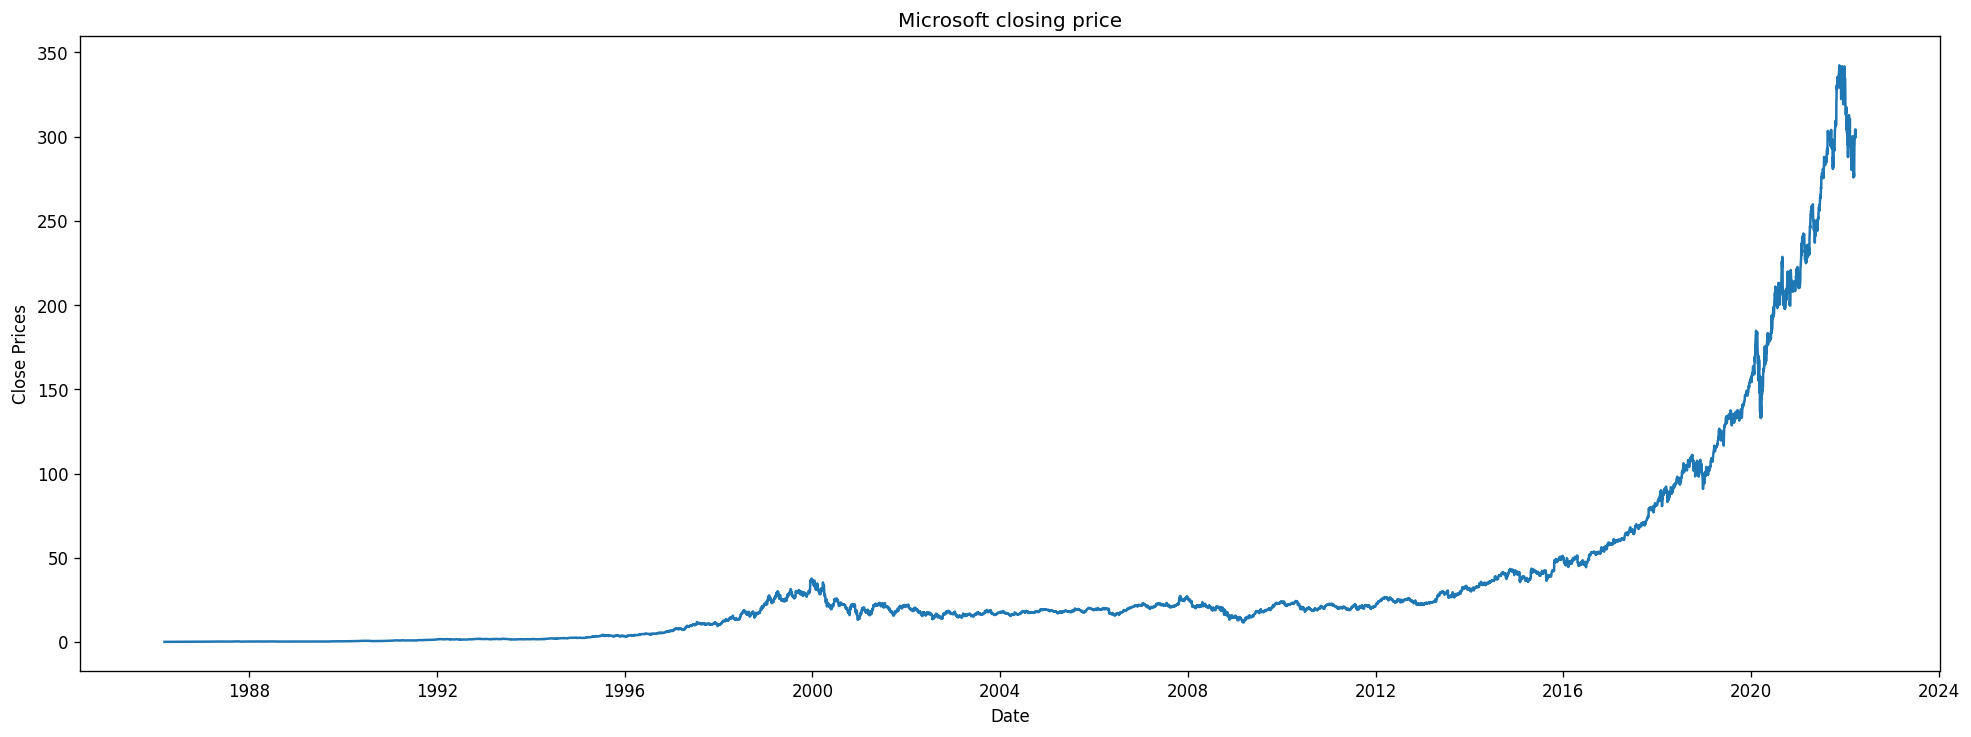

In [62]:
#plot close price
plt.figure(figsize=(20,7), dpi=120)
# plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Adj Close'])
plt.title('Microsoft closing price')
plt.show()

<AxesSubplot:ylabel='Density'>

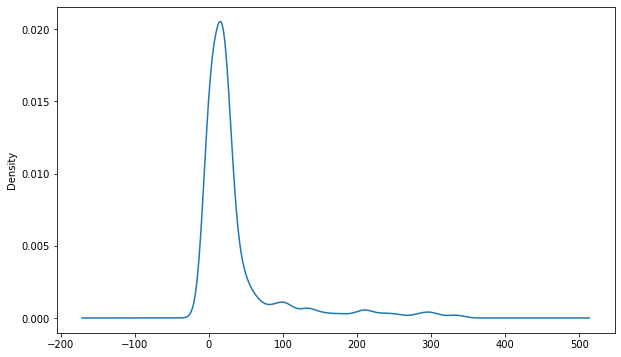

In [63]:
#Distribution of the dataset
df_close = stock_data['Adj Close']
df_close.plot(kind='kde')

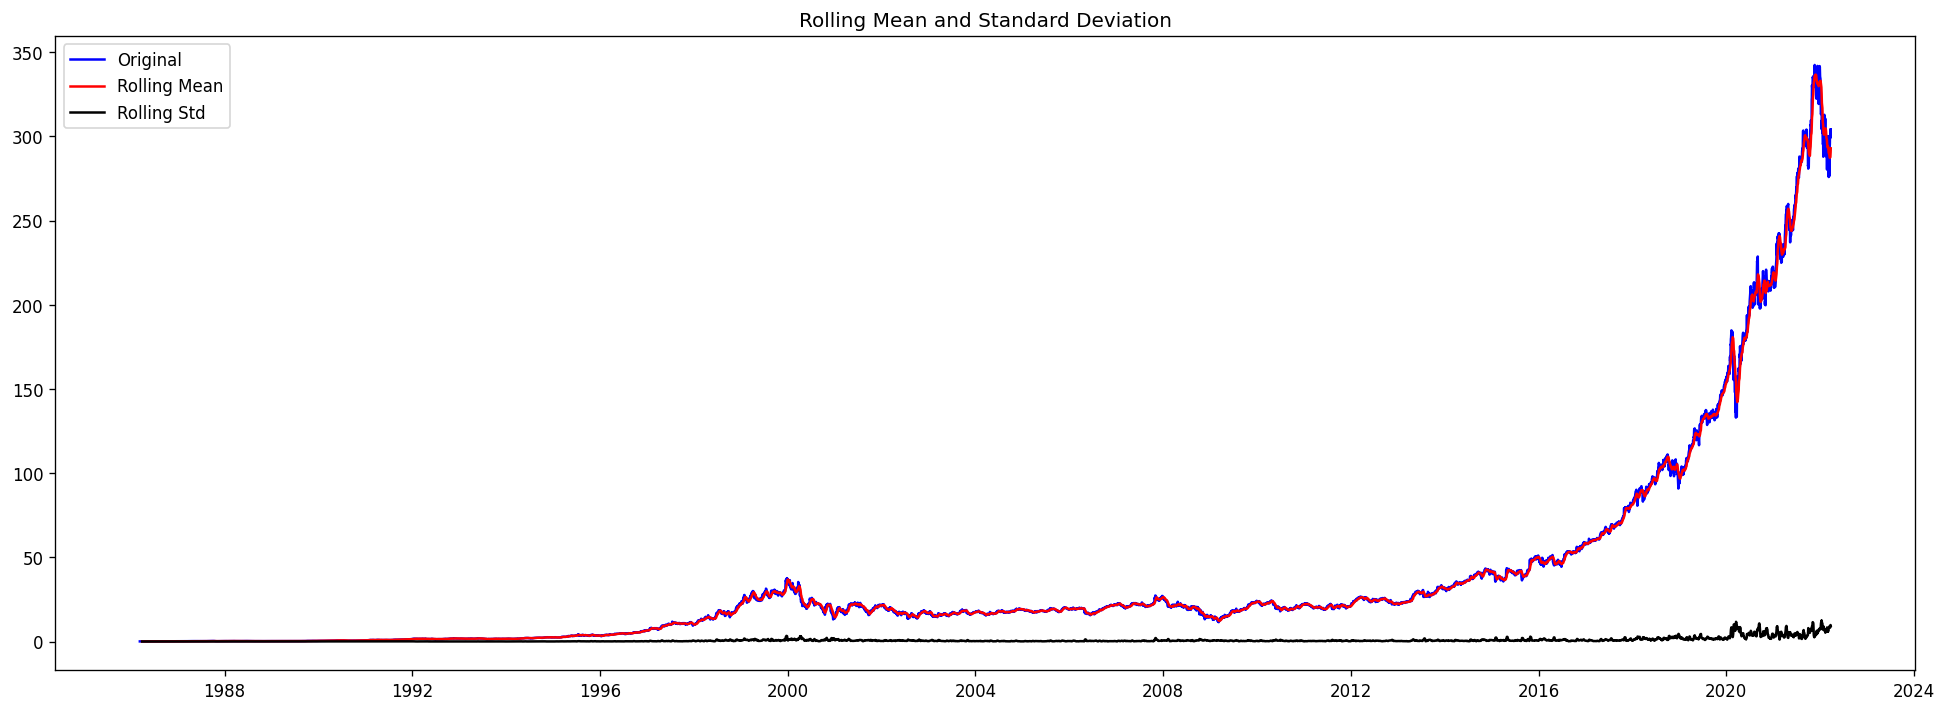

Results of dickey fuller test
Test Statistics                   5.894460
p-value                           1.000000
No. of lags used                 38.000000
Number of observations used    9044.000000
critical value (1%)              -3.431073
critical value (5%)              -2.861860
critical value (10%)             -2.566940
dtype: float64


In [64]:
#Test for staionarity
def test_stationarity(timeseries):
  #Determing rolling statistics
  rolmean = timeseries.rolling(12).mean()
  rolstd = timeseries.rolling(12).std()

  #Plot rolling statistics:
  plt.figure(figsize=(20,7), dpi=120)
  plt.plot(timeseries, color='blue',label='Original')
  plt.plot(rolmean, color='red', label='Rolling Mean')
  plt.plot(rolstd, color='black', label = 'Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean and Standard Deviation')
  plt.show(block=False)
  print("Results of dickey fuller test")
  adft = adfuller(timeseries,autolag='AIC')
  # output for dft will give us without defining what the values are.
  #hence we manually write what values does it explains using a for loop
  output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
  for key,values in adft[4].items():
    output['critical value (%s)'%key] =  values
  print(output)
test_stationarity(df_close)

<Figure size 720x432 with 0 Axes>

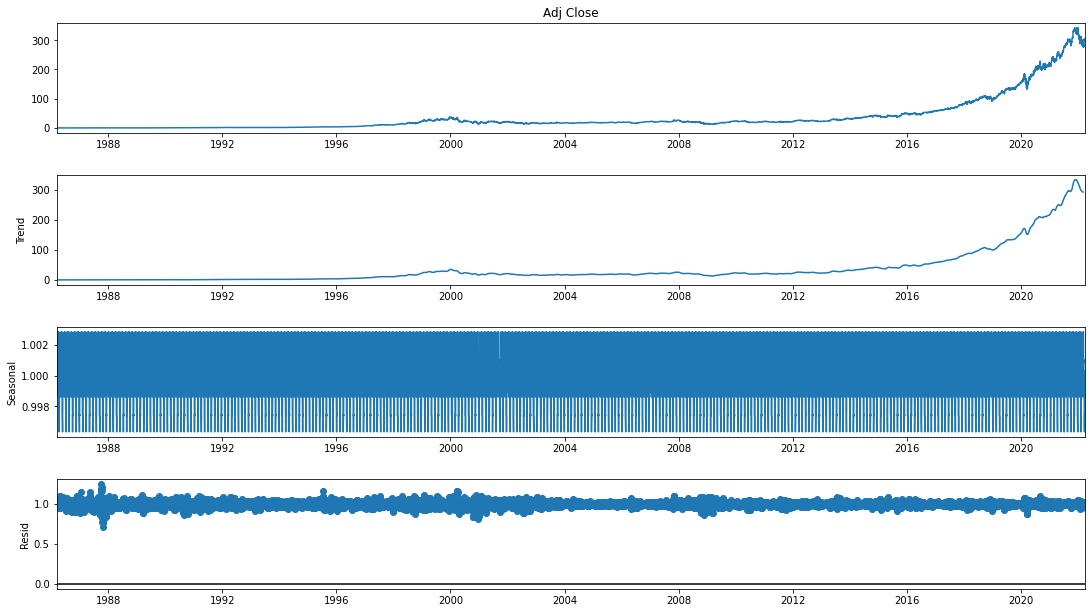

In [65]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


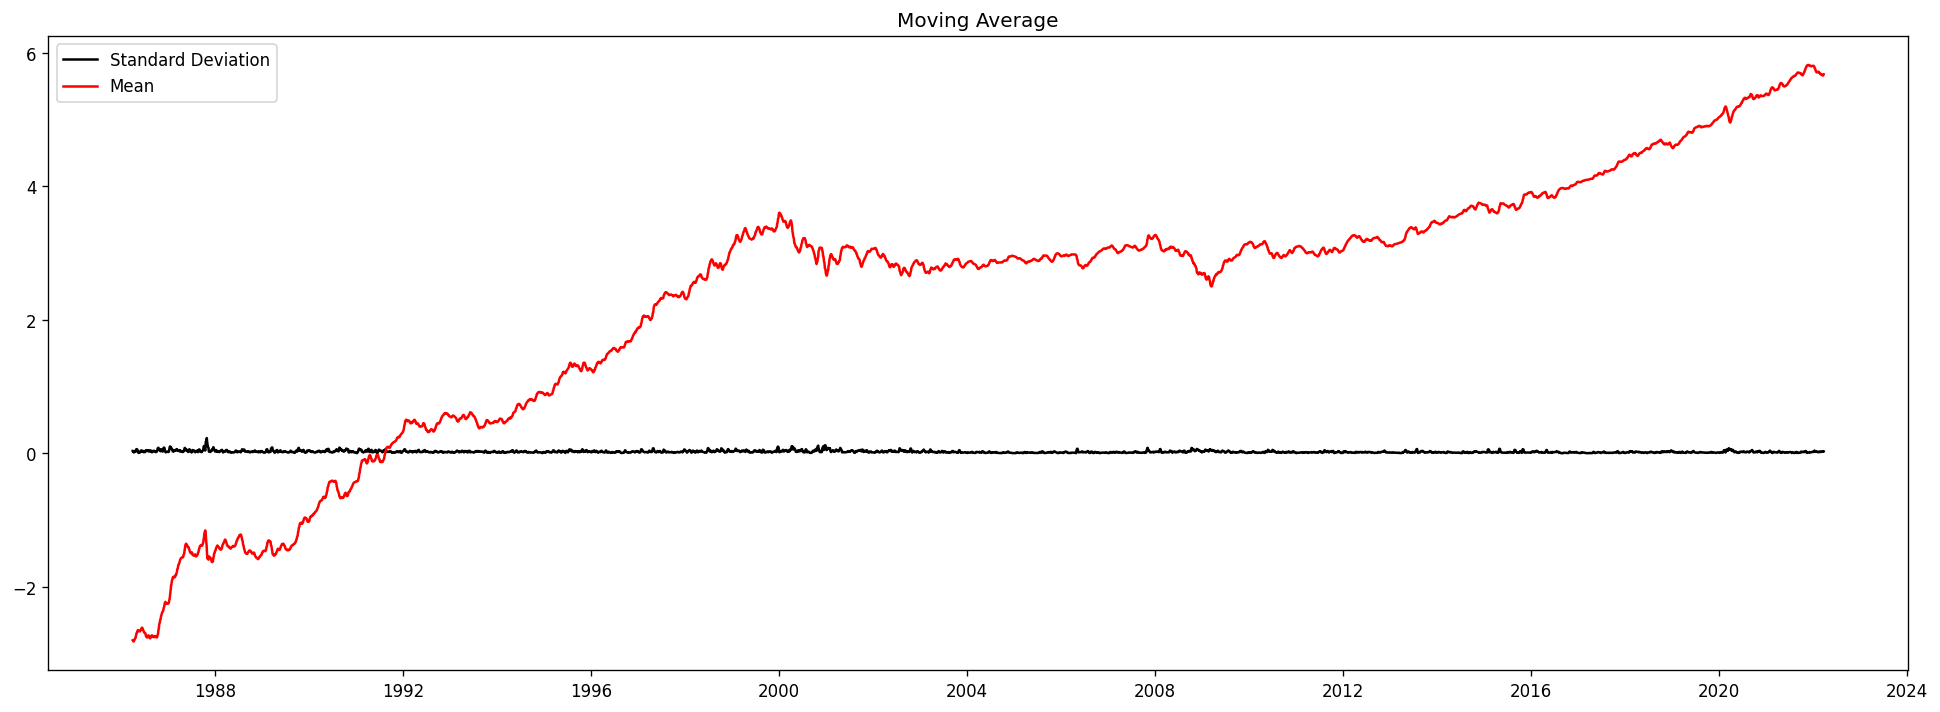

In [66]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
# rcParams['figure.figsize'] = 10, 6
plt.figure(figsize=(20,7), dpi=120)
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
# plt.show()

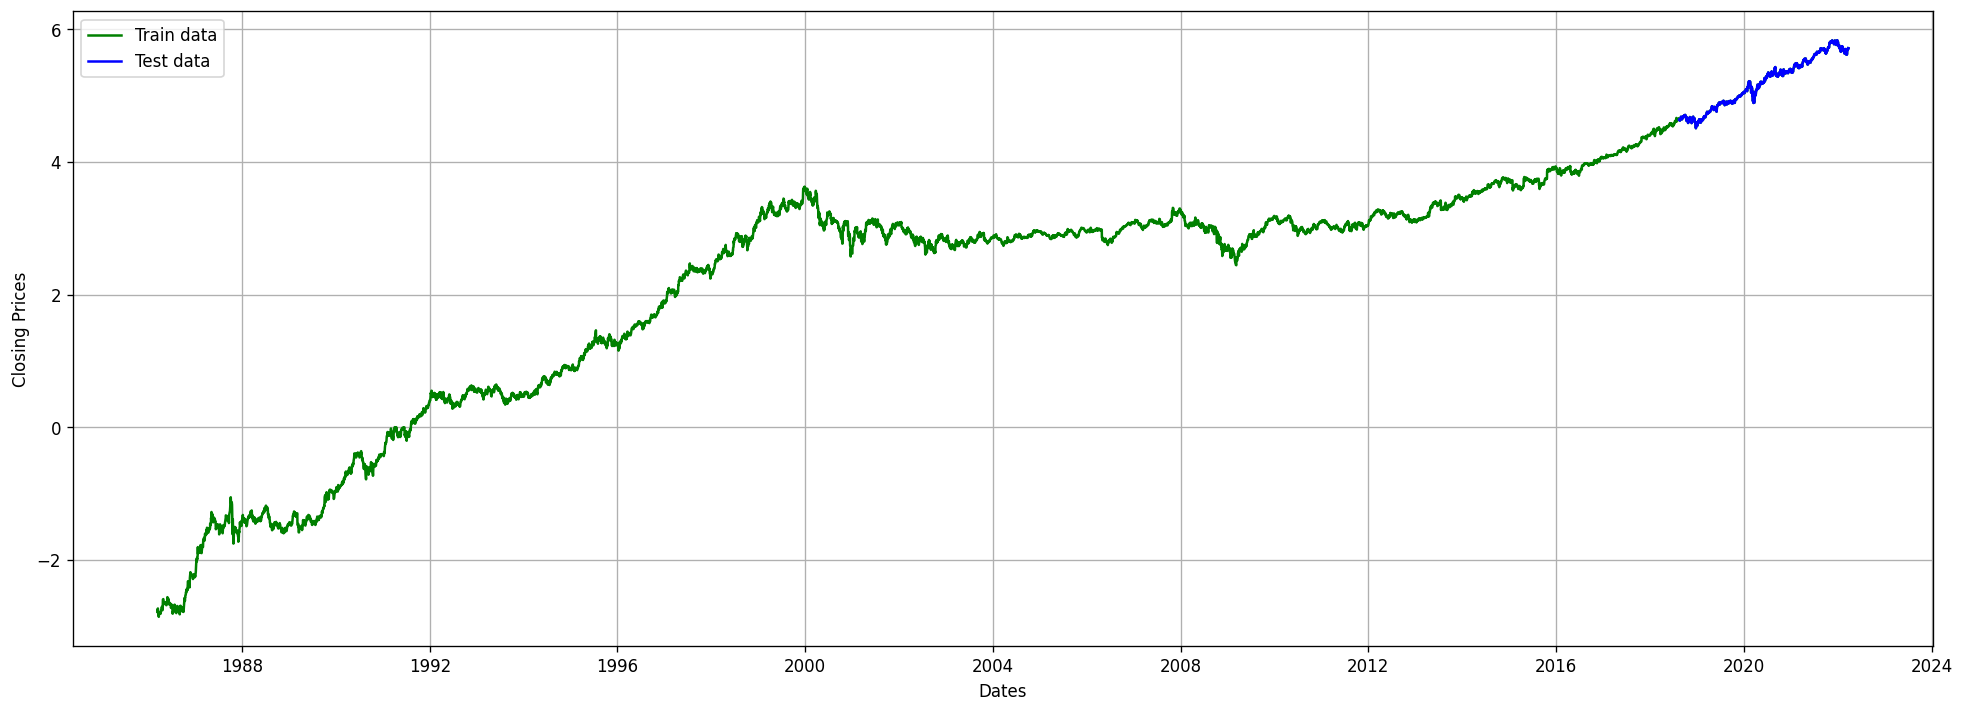

In [67]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(20,7), dpi=120)
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-39493.453, Time=0.74 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-39491.596, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-39491.585, Time=1.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-39481.006, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-39496.062, Time=2.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-39511.196, Time=1.47 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-39506.675, Time=0.51 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-39510.209, Time=1.98 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-39513.662, Time=1.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-39513.629, Time=2.96 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-39511.406, Time=2.49 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-39510.980, Time=2.43 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-39512.881, Time=2.53 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-39510.985, Time=2.78 sec
 ARIM

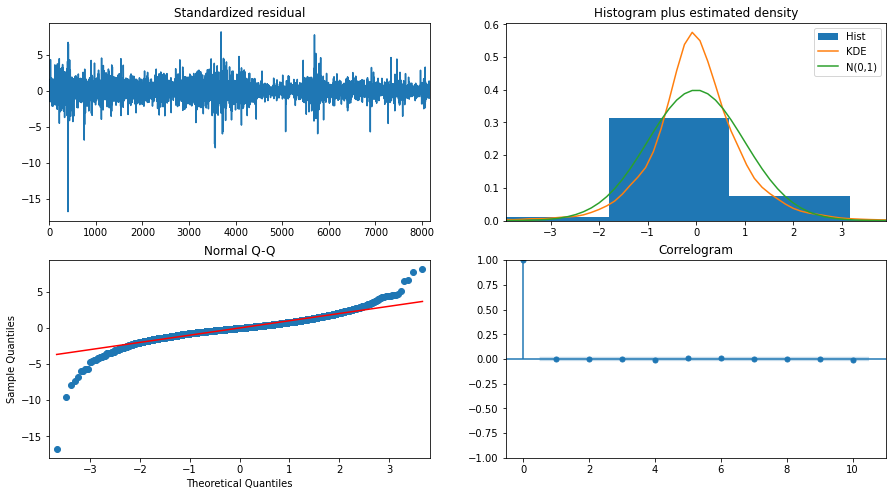

In [68]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [71]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 8171
Model:                 ARIMA(1, 1, 2)   Log Likelihood               19753.254
Date:                Thu, 12 May 2022   AIC                         -39498.508
Time:                        16:59:21   BIC                         -39470.475
Sample:                             0   HQIC                        -39488.923
                               - 8171                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5091      0.098      5.169      0.000       0.316       0.702
ma.L1         -0.5052      0.098     -5.177      0.000      -0.696      -0.314
ma.L2         -0.0463      0.007     -6.951      0.0

In [76]:
# Forecast
# fc, se, conf = fitted.forecast(321, alpha=0.05)
print(fitted.forecast(321 , alpha=0.05).summary())  # 95% conf



AttributeError: 'Series' object has no attribute 'summary'

In [ ]:

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()